In [1]:
!pip install alns
!pip install tsplib95

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from alns import ALNS
from alns.accept import HillClimbing
from alns.select import RouletteWheel
from alns.stop import MaxRuntime
from alns.select import SegmentedRouletteWheel
import copy

In [3]:
import tsplib95
import tsplib95.distances as distances

In [4]:
DATA = tsplib95.load('/content/xqf131 3D.tsp')
POIS = list(DATA.node_coords.keys())

In [5]:
COORDS = DATA.node_coords.values()

In [6]:
import math

# Funzione per calcolare la distanza tra due nodi considerando latitudine, longitudine e altitudine
def calculate_distance(coord1, coord2):
    R = 6371000  # Raggio della Terra in metri

    lat1 = math.radians(coord1[0])
    lon1 = math.radians(coord1[1])
    lat2 = math.radians(coord2[0])
    lon2 = math.radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    planar_distance = R * c

    # Calcola la distanza totale considerando anche la differenza di altitudine
    delta_altitude = coord1[2] - coord2[2]
    total_distance = math.sqrt(planar_distance**2 + delta_altitude**2)

    return total_distance


# Precompilazione della matrice delle distanze
DIST = np.empty((len(COORDS) + 1, len(COORDS) + 1))

for row, coord1 in enumerate(COORDS, 1):
    for col, coord2 in enumerate(COORDS, 1):
        if row == col:
            DIST[row, col] = 0
        else:
            DIST[row, col] = calculate_distance(coord1, coord2)

print(DIST)


[[4.04738577e-320 5.25685847e-321 0.00000000e+000 ... 1.38338381e-322
  1.08221785e-312 0.00000000e+000]
 [4.95238849e-310 0.00000000e+000 1.44553405e+006 ... 9.40308051e+006
  9.34536487e+006 1.18400782e+007]
 [9.88131292e-324 1.44553405e+006 0.00000000e+000 ... 9.35500487e+006
  9.38074364e+006 1.18975605e+007]
 ...
 [0.00000000e+000 9.40308051e+006 9.35500487e+006 ... 0.00000000e+000
  3.67172669e+005 2.54831240e+006]
 [0.00000000e+000 9.34536487e+006 9.38074364e+006 ... 3.67172669e+005
  0.00000000e+000 2.52418058e+006]
 [0.00000000e+000 1.18400782e+007 1.18975605e+007 ... 2.54831240e+006
  2.52418058e+006 0.00000000e+000]]


In [7]:
class TspState:
    """
    Solution class for the TSP problem. It has two data members, nodes, and edges.
    nodes is a list of IDs. The edges data member, then, is a mapping from each node
    to their only outgoing node.
    """

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def objective(self):
        """
        The objective function is simply the sum of all individual edge lengths,
        using the rounded Euclidean norm.
        """
        return sum(DIST[node, self.edges[node]] for node in self.nodes)

    def to_graph(self):
        """
        NetworkX helper method.
        """
        graph = nx.Graph()

        for node in self.nodes:
            graph.add_node(node, pos=DATA.node_coords[node])

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from, node_to)

        return graph

In [8]:
random_state = rnd.RandomState(7654)
state = TspState(POIS, {})

In [9]:
def would_form_subcycle(from_node, to_node, state):
    """
    Ensures the proposed solution would not result in a cycle smaller
    than the entire set of nodes. Notice the offsets: we do not count
    the current node under consideration, as it cannot yet be part of
    a cycle.
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]

        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False

In [10]:
def greedy_repair(current, rnd_state):
    """
    Greedily repairs a tour, stitching up nodes that are not departed
    with those not visited.
    """
    visited = set(current.edges.values())

    # This kind of randomness ensures we do not cycle between the same
    # destroy and repair steps every time.
    shuffled_idcs = rnd_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes
                    if node not in current.edges)

        # Computes all nodes that have not currently been visited,
        # that is, those that this node might visit. This should
        # not result in a subcycle, as that would violate the TSP
        # constraints.
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # Closest visitable node.
        nearest = min(unvisited,
                      key=lambda other: DIST[node, other])

        current.edges[node] = nearest
        visited.add(nearest)

    return current

In [11]:
random_state = rnd.RandomState(7654)

init_sol = greedy_repair(state, random_state)
print(f"Initial solution objective is {init_sol.objective()}.")


Initial solution objective is 83279425.78723253.


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
def draw_graph_3d(graph, node_coords, only_nodes=False):
    """
    Helper method for drawing TSP (tour) graphs in 3D.
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos = {i: (node_coords[i][0], node_coords[i][1], node_coords[i][2]) for i in range(1,len(node_coords)+1)}

     # Convert node_coords to a dictionary if it's not already
    # if isinstance(node_coords, dict):
    #     pos = node_coords
    # else:
    #     pos = {i: coord for i, coord in enumerate(node_coords)}

    # Draw nodes
    xs = [pos[i][0] for i in pos]
    ys = [pos[i][1] for i in pos]
    zs = [pos[i][2] for i in pos]
    ax.scatter(xs, ys, zs, c='r', marker='o')

    if not only_nodes:
        # Draw edges
        for edge in graph.edges:
          if edge[0] in pos and edge[1] in pos: # Check if both nodes exist
            x = [pos[edge[0]][0], pos[edge[1]][0]]
            y = [pos[edge[0]][1], pos[edge[1]][1]]
            z = [pos[edge[0]][2], pos[edge[1]][2]]
            ax.plot(x, y, z, c='b')

    # Labeling the nodes (optional)
    for i, coord in pos.items():
        ax.text(coord[0], coord[1], coord[2], str(i), color='black')

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    plt.show()


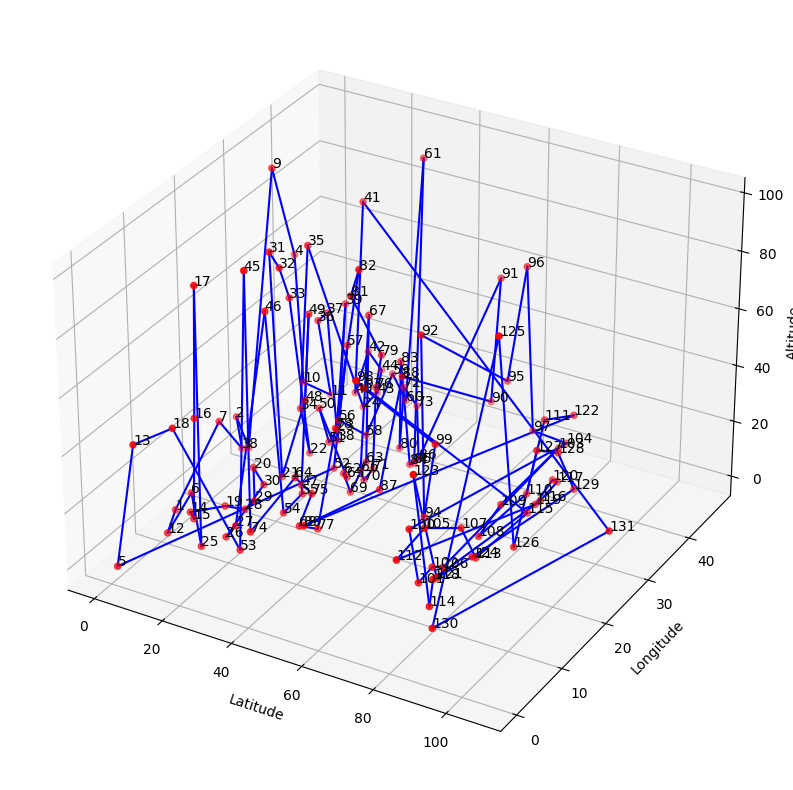

In [14]:
draw_graph_3d(init_sol.to_graph(), DATA.node_coords, only_nodes=False)

# **DESTROY OPERATORS**

In [15]:
DEGREE_OF_DESTRUCTION = 0.1

def edges_to_remove(state):
    return int(len(state.edges) * DEGREE_OF_DESTRUCTION)

def worst_removal(current, rnd_state):
    """
    Worst removal iteratively removes the 'worst' edges, that is,
    those edges that have the largest distance.
    """
    destroyed = copy.deepcopy(current)

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: DIST[node, destroyed.edges[node]])

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-(idx + 1)]]

    return destroyed

def path_removal(current, rnd_state):
    """
    Removes an entire consecutive sub-path, that is, a series of
    contiguous edges.
    """
    destroyed = copy.deepcopy(current)

    node_idx = rnd_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]

    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed


def random_removal(current, rnd_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = copy.deepcopy(current)

    for idx in rnd_state.choice(len(destroyed.nodes),
                                edges_to_remove(current),
                                replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed


In [16]:
alns = ALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [23]:

select = SegmentedRouletteWheel([3, 2, 1, 0.5], 0.8, 500, 3, 1)
accept = HillClimbing()
stop = MaxRuntime(180)

result = alns.iterate(init_sol, select, accept, stop)

In [24]:
solution = result.best_state
objective = solution.objective()

In [25]:
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 53773152.63341651.


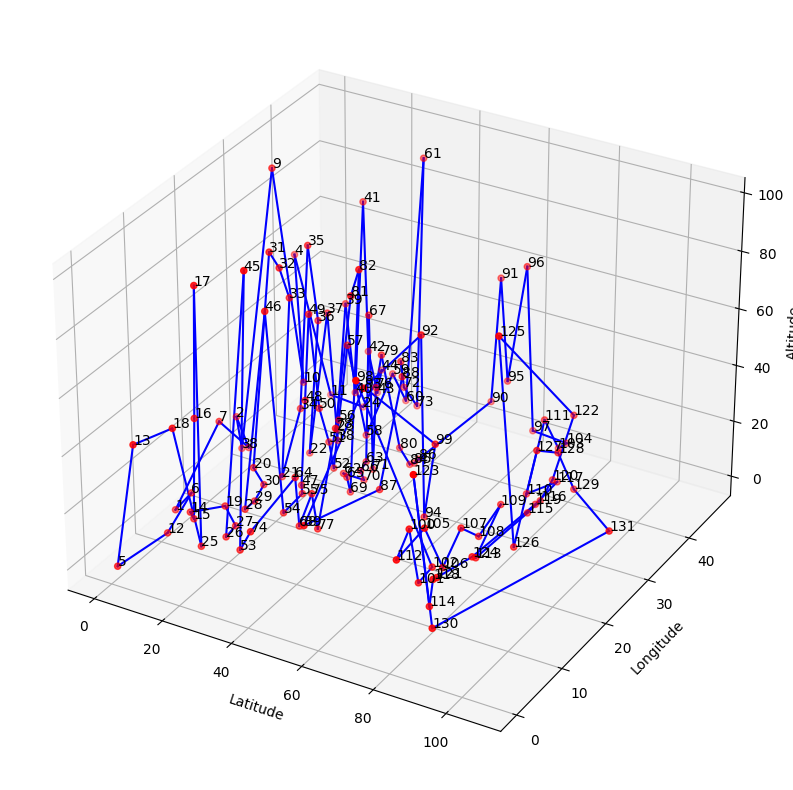

In [26]:
draw_graph_3d(solution.to_graph(), DATA.node_coords, only_nodes=False)

In [27]:
pct_diff = 100 * (objective - init_sol.objective()) / init_sol.objective()
print(f"Improvement is {pct_diff:.2f}%.")


Improvement is -35.43%.
